In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, LearningRateScheduler
import time

PLOT=True
# PLOT=False

SEQ_LEN=60

In [2]:
%load_ext tensorboard

In [3]:
url = "./datasets/DAT_ASCII_EURUSD_M1_2017.csv"
df = pd.read_csv(url, names=list(["date","open", "high", "low", "close", "volume"]), header=None, sep=";")
df.drop("volume", 1, inplace=True)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.set_index('date', inplace=True)

df.head()

,open,high,low,close
date,,,,
2017-01-02 02:00:00,1.05155,1.05197,1.05155,1.05190
2017-01-02 02:01:00,1.05209,1.05209,1.05177,1.05179
2017-01-02 02:02:00,1.05177,1.05198,1.05177,1.05178
2017-01-02 02:03:00,1.05188,1.05200,1.05188,1.05200
2017-01-02 02:04:00,1.05196,1.05204,1.05196,1.05203


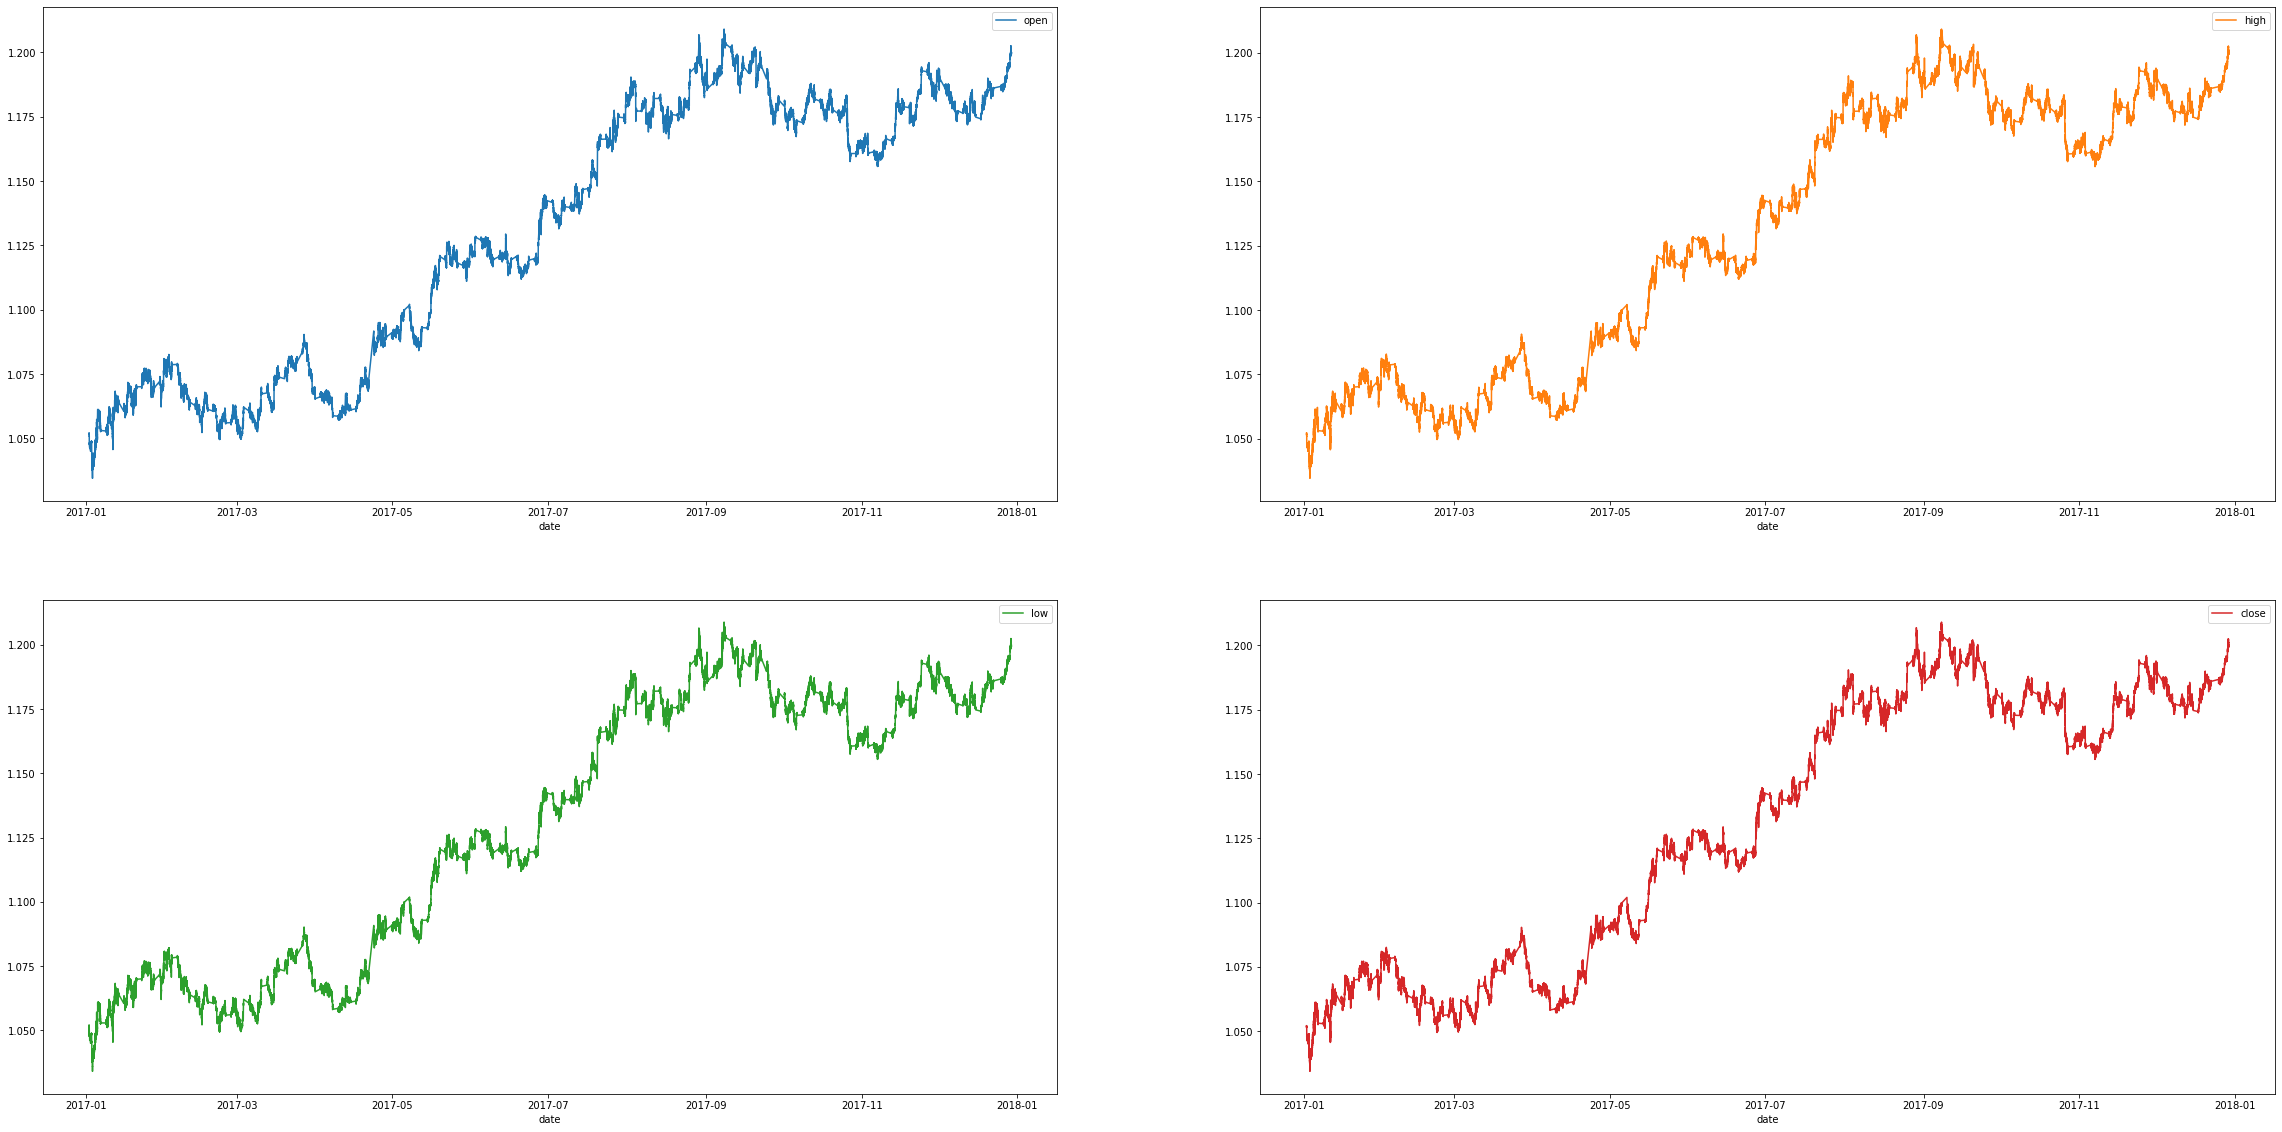

In [4]:
if PLOT:
    df.plot(subplots=True, layout=(2, 2), figsize=(40, 20), sharex=False)

In [5]:
data_set = df.iloc[:, 2:3].values #close
print(data_set)

[[1.05155]
 [1.05177]
 [1.05177]
 ...
 [1.19961]
 [1.19974]
 [1.1998 ]]


In [6]:
print(data_set.shape)

(371635, 1)


In [7]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(data_set)
print(data_set)

[[1.05155]
 [1.05177]
 [1.05177]
 ...
 [1.19961]
 [1.19974]
 [1.1998 ]]


In [8]:
X_train = []
y_train = []
for i in range(SEQ_LEN, training_set_scaled.size-1):
    X_train.append(training_set_scaled[i-SEQ_LEN:i, 0])
    y_train.append(training_set_scaled[i+1, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train[0])

[0.10006866 0.10132738 0.10132738 0.10195675 0.10241446 0.10241446
 0.1029294  0.10315826 0.10310104 0.10304383 0.10327269 0.10338712
 0.10315826 0.10298661 0.10321547 0.10310104 0.10327269 0.10132738
 0.10127017 0.10104131 0.10109852 0.10127017 0.10167067 0.10127017
 0.10167067 0.1013846  0.10149903 0.10132738 0.10155624 0.10132738
 0.1017851  0.10212839 0.10252889 0.10264332 0.10275775 0.10264332
 0.10161346 0.10189953 0.10115574 0.10075524 0.10075524 0.10069802
 0.10086966 0.10092688 0.10041195 0.10069802 0.10058359 0.0998398
 0.09966815 0.09989701 0.0994393  0.09955372 0.09852386 0.09875272
 0.098295   0.0986955  0.09858107 0.09978258 0.09955372 0.09995423]


In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train[0])

[[0.10006866]
 [0.10132738]
 [0.10132738]
 [0.10195675]
 [0.10241446]
 [0.10241446]
 [0.1029294 ]
 [0.10315826]
 [0.10310104]
 [0.10304383]
 [0.10327269]
 [0.10338712]
 [0.10315826]
 [0.10298661]
 [0.10321547]
 [0.10310104]
 [0.10327269]
 [0.10132738]
 [0.10127017]
 [0.10104131]
 [0.10109852]
 [0.10127017]
 [0.10167067]
 [0.10127017]
 [0.10167067]
 [0.1013846 ]
 [0.10149903]
 [0.10132738]
 [0.10155624]
 [0.10132738]
 [0.1017851 ]
 [0.10212839]
 [0.10252889]
 [0.10264332]
 [0.10275775]
 [0.10264332]
 [0.10161346]
 [0.10189953]
 [0.10115574]
 [0.10075524]
 [0.10075524]
 [0.10069802]
 [0.10086966]
 [0.10092688]
 [0.10041195]
 [0.10069802]
 [0.10058359]
 [0.0998398 ]
 [0.09966815]
 [0.09989701]
 [0.0994393 ]
 [0.09955372]
 [0.09852386]
 [0.09875272]
 [0.098295  ]
 [0.0986955 ]
 [0.09858107]
 [0.09978258]
 [0.09955372]
 [0.09995423]]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
model = Sequential()

model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

opt = Adam(lr=0.001, decay=1e-6)

NAME = f"PRED-{int(time.time())}"  
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME, update_freq=25))
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.0001)


def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    return lr / (epoch*3)  

lr_scheduler_cb=LearningRateScheduler(schedule=scheduler)

model.compile(optimizer=opt,loss='mean_squared_error')

model.fit(X_train,y_train,epochs=30,batch_size=256,validation_data=(X_test, y_test),callbacks=[lr_scheduler_cb])

model.save(f"models/{NAME}_model.h5")

score=model.evaluate(X_test, y_test, verbose=1) 

Epoch 1/30
1162/1162 [==============================] - 192s 165ms/step - loss: 0.0039 - val_loss: 1.2842e-04
Epoch 2/30
1162/1162 [==============================] - 200s 172ms/step - loss: 0.0014 - val_loss: 9.9822e-05
Epoch 3/30
1162/1162 [==============================] - 205s 176ms/step - loss: 9.2061e-04 - val_loss: 1.8293e-04
Epoch 4/30
1162/1162 [==============================] - 207s 178ms/step - loss: 6.5341e-04 - val_loss: 3.1553e-04
Epoch 5/30
1162/1162 [==============================] - 209s 180ms/step - loss: 5.4924e-04 - val_loss: 7.8330e-05
Epoch 6/30
1162/1162 [==============================] - 206s 178ms/step - loss: 5.2096e-04 - val_loss: 1.4550e-05
Epoch 7/30
1162/1162 [==============================] - 207s 178ms/step - loss: 5.1778e-04 - val_loss: 2.4415e-05
Epoch 8/30
1162/1162 [==============================] - 218s 188ms/step - loss: 5.0763e-04 - val_loss: 3.2883e-05
Epoch 9/30
1162/1162 [==============================] - 230s 198ms/step - loss: 5.0098e-04 - val

In [14]:
print(NAME)

PRED-1592157754
